In [4]:
import yaml
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from datetime import datetime

# Importation de VOTRE logique métier depuis le fichier traitement.py
# Assurez-vous que traitement.py est bien dans le même dossier
try:
    from traitement import Requete, Modele
    print("✅ Classes importées avec succès depuis traitement.py")
except ImportError as e:
    print(f"❌ Erreur : Impossible d'importer traitement.py. Vérifiez qu'il est dans le dossier.\nDétail: {e}")

✅ Classes importées avec succès depuis traitement.py


In [6]:
# --- 1. Définition des fichiers attendus ---

FILES = {
    "config": "config/config.yaml",
    "model": "config/config_model.yaml",
    "data": "data/2025-FluidTopics-daily-analytics.yaml"
}


def check_and_load(filename):
    """Vérifie l'existence du fichier avant de charger pour éviter les crashs."""
    path = Path(filename)
    if not path.exists():
        print(f"❌ ERREUR CRITIQUE : Le fichier '{filename}' est introuvable.")
        print(f"   Dossier actuel : {os.getcwd()}")
        print("   👉 Veuillez uploader ce fichier dans le même dossier que ce notebook.")
        return None
    
    with open(path, 'r', encoding='utf-8') as f:
        print(f"✅ Chargement réussi : {filename}")
        return yaml.safe_load(f)

# --- 2. Chargement sécurisé ---
print("--- Vérification des fichiers ---")
cfg_global = check_and_load(FILES["config"])
cfg_models = check_and_load(FILES["model"])
data_analytics = check_and_load(FILES["data"])

# --- 3. Arrêt d'urgence si fichiers manquants ---
if cfg_global is None or cfg_models is None or data_analytics is None:
    print("\n⛔ ARRÊT DU SCRIPT : Fichiers manquants.")
    print("Assurez-vous d'avoir uploadé 'config.yaml', 'config_model.yaml' et le fichier analytics.")
    # On lève une erreur pour stopper l'exécution des cellules suivantes
    raise FileNotFoundError("Un ou plusieurs fichiers de configuration sont manquants.")

# --- 4. Suite normale (si tout va bien) ---
try:
    region_key = cfg_global.get('default_region', 'france')
    region_specs = cfg_global['regions'][region_key]
    
    # Extraction des variables
    PUE = region_specs['pue']
    CARBON_INTENSITY = region_specs['carbon_intensity_g_per_kwh']
    GPU_SPECS = cfg_models['hardware']['gpu']
    CPU_SPECS = cfg_models['hardware']['cpu']

    print(f"\n🌍 Contexte chargé : {region_key.upper()}")
    print(f"   PUE: {PUE} | Carbone: {CARBON_INTENSITY} gCO2e/kWh")

except KeyError as e:
    print(f"❌ Erreur de structure dans le YAML : Clé manquante {e}")
    raise

--- Vérification des fichiers ---
✅ Chargement réussi : config/config.yaml
✅ Chargement réussi : config/config_model.yaml
✅ Chargement réussi : data/2025-FluidTopics-daily-analytics.yaml

🌍 Contexte chargé : FRANCE
   PUE: 1.3 | Carbone: 60 gCO2e/kWh


In [7]:
results = []

# Mapping entre les clés du fichier analytics et les profils du fichier modèle
# Analytics (fichier de données) : Config (fichier modèle)
MAPPING = {
    'chatbots': 'chatbot',
    'completions': 'completion',
    'translations': 'translation'
}

print("🚀 Démarrage des calculs...\n")

for analytics_cat, profile_key in MAPPING.items():
    # 1. Récupération des données brutes
    entries = data_analytics['genai'].get(analytics_cat, [])
    if not entries:
        continue
        
    # 2. Récupération du profil type (taille input/output)
    profile = cfg_models['profiles'].get(profile_key, {})
    
    # Valeurs par défaut si non spécifiées dans le YAML
    input_size = profile.get('input_characters', 1000) 
    output_size = profile.get('output_characters', 500)
    throughput = profile.get('throughput_tokens_per_s', 60)
    util_rate = profile.get('utilization_rate', 1.0)
    
    # 3. Création de la REQUÊTE type (Logique traitement.py)
    # On instancie la classe Requete importée
    req = Requete(name=profile_key)
    req.add_topics(input_size) # On considère l'input comme un "topic" pour le calcul
    req.output_size = output_size
    
    # 4. Création du MODÈLE type (Logique traitement.py)
    # On instancie la classe Modele importée
    modele = Modele(
        name=f"Model_{profile_key}",
        requete=req,
        pue=PUE,
        intensite_carbone=CARBON_INTENSITY,
        utilization_rate=util_rate,
        etat_CPU=CPU_SPECS['eta'],
        power_CPU=CPU_SPECS['power_w'],
        power_GPU=GPU_SPECS['power_w'],
        tokens_per_hour=int(throughput * 3600)
    )
    
    # 5. Calculs Unitaires
    # Appel des méthodes de votre script traitement.py
    impact_unitaire_gCO2 = modele.empreinte_requete()
    energie_unitaire_joules = modele.get_energie_total()
    temps_calcul = modele.get_t_compute()
    
    print(f"[{profile_key.upper()}]")
    print(f"   Input: {input_size} | Output: {output_size} | Vitesse: {throughput} tok/s")
    print(f"   ⏱️ Temps calcul (formule quadratique): {temps_calcul:.4f} s")
    print(f"   💨 Impact unitaire: {impact_unitaire_gCO2:.4f} gCO2e")
    print("-" * 30)

    # 6. Application aux volumes journaliers
    for entry in entries:
        results.append({
            'date': pd.to_datetime(entry['date']),
            'service_type': analytics_cat,
            'requests_count': entry['count'],
            'total_gCO2e': entry['count'] * impact_unitaire_gCO2,
            'total_kWh': (entry['count'] * energie_unitaire_joules) / 3_600_000
        })

# Création du DataFrame final
df = pd.DataFrame(results)
print(f"\n✅ Calcul terminé. {len(df)} jours traités.")

🚀 Démarrage des calculs...

[CHATBOT]
   Input: 1000 | Output: 500 | Vitesse: 60 tok/s
   ⏱️ Temps calcul (formule quadratique): 16675.0000 s
   💨 Impact unitaire: 218.7621 gCO2e
------------------------------
[COMPLETION]
   Input: 2500 | Output: 300 | Vitesse: 60 tok/s
   ⏱️ Temps calcul (formule quadratique): 104171.6667 s
   💨 Impact unitaire: 1366.6455 gCO2e
------------------------------
[TRANSLATION]
   Input: 3000 | Output: 3000 | Vitesse: 60 tok/s
   ⏱️ Temps calcul (formule quadratique): 150050.0000 s
   💨 Impact unitaire: 1968.5310 gCO2e
------------------------------

✅ Calcul terminé. 301 jours traités.


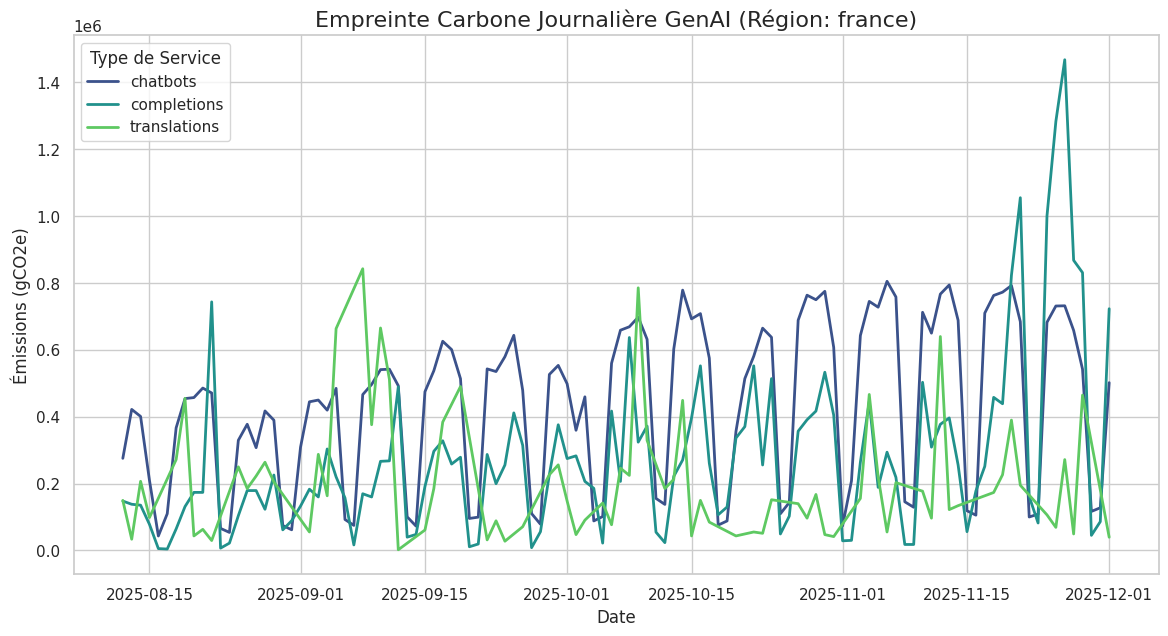

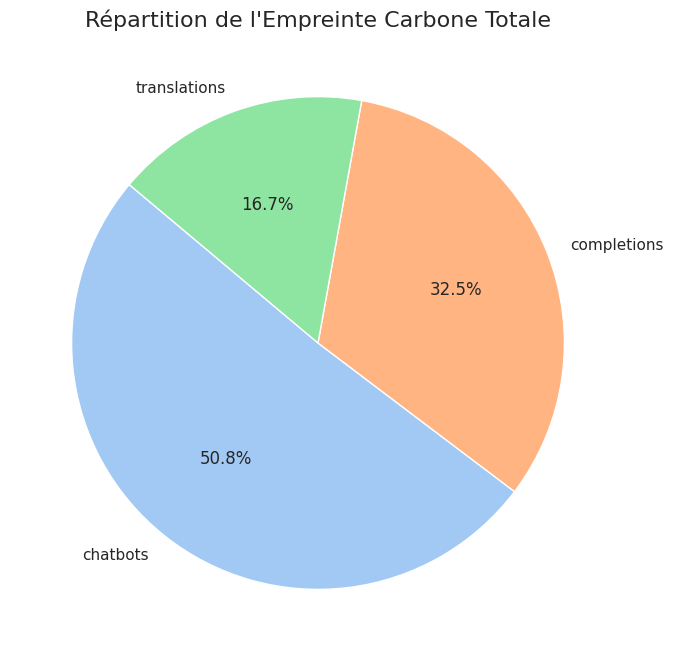

BILAN GLOBAL SUR LA PÉRIODE
🌍 Total Émissions : 96388.62 kgCO2e
⚡ Total Énergie   : 1606477.03 kWh
📅 Période         : du 2025-08-12 au 2025-12-01


,date,service_type,requests_count,total_gCO2e,total_kWh
202,2025-11-10,completions,368,502925.528156,8382.092136
156,2025-09-25,completions,301,411360.282540,6856.004709
160,2025-09-29,completions,166,226863.145853,3781.052431
239,2025-09-03,translations,146,287405.519917,4790.091999
66,2025-10-17,chatbots,2630,575344.333958,9589.072233


In [8]:
if not df.empty:
    # --- Configuration Graphique ---
    sns.set_theme(style="whitegrid")
    plt.figure(figsize=(14, 7))
    
    # --- Graphique 1 : Évolution temporelle par service ---
    sns.lineplot(
        data=df, 
        x='date', 
        y='total_gCO2e', 
        hue='service_type', 
        palette="viridis",
        linewidth=2
    )
    
    plt.title(f"Empreinte Carbone Journalière GenAI (Région: {region_key})", fontsize=16)
    plt.ylabel("Émissions (gCO2e)", fontsize=12)
    plt.xlabel("Date", fontsize=12)
    plt.legend(title="Type de Service")
    plt.show()
    
    # --- Graphique 2 : Répartition Totale ---
    plt.figure(figsize=(8, 8))
    total_per_cat = df.groupby('service_type')['total_gCO2e'].sum()
    
    plt.pie(
        total_per_cat, 
        labels=total_per_cat.index, 
        autopct='%1.1f%%', 
        startangle=140, 
        colors=sns.color_palette("pastel")
    )
    plt.title("Répartition de l'Empreinte Carbone Totale", fontsize=16)
    plt.show()

    # --- KPI Finaux ---
    total_co2_kg = df['total_gCO2e'].sum() / 1000
    total_energy_kwh = df['total_kWh'].sum()
    
    print("="*40)
    print("BILAN GLOBAL SUR LA PÉRIODE")
    print("="*40)
    print(f"🌍 Total Émissions : {total_co2_kg:.2f} kgCO2e")
    print(f"⚡ Total Énergie   : {total_energy_kwh:.2f} kWh")
    print(f"📅 Période         : du {df['date'].min().date()} au {df['date'].max().date()}")
    print("="*40)
    
    # Aperçu des données
    display(df.sample(5))

else:
    print("⚠️ Aucune donnée n'a été générée. Vérifiez les fichiers d'entrée.")

In [1]:
# ==========================================
# 🔎 EXEMPLE : Calcul sur une requête unique
# ==========================================
from traitement import Requete, Modele, load_configs

# 1. Chargement des configurations (pour avoir les specs GPU et le mix électrique)
conf_global, conf_model = load_configs()

# 2. Paramètres du scénario
region_cible = "usa"       # Testons l'impact aux USA (mix carboné élevé)
input_tokens = 2000        # Longueur du prompt
output_tokens = 500        # Longueur de la réponse générée

# 3. Extraction des paramètres depuis les configs chargées
specs_region = conf_global["regions"][region_cible]
specs_gpu = conf_model["hardware"]["gpu"]
specs_cpu = conf_model["hardware"]["cpu"]

# 4. Création de l'objet Requête
req = Requete(name="Demo_Notebook")
req.add_topics(input_tokens)   # On simule l'entrée
req.output_size = output_tokens

# 5. Création du Modèle (le "Moteur" de calcul)
# On fixe ici une vitesse de 60 tokens/seconde (standard)
vitesse_tok_sec = 60 

modele = Modele(
    name="GPT-Sim",
    requete=req,
    # Paramètres d'infrastructure
    pue=specs_region["pue"],
    intensite_carbone=specs_region["carbon_intensity_g_per_kwh"],
    # Paramètres Hardware
    power_GPU=specs_gpu["power_w"],
    power_CPU=specs_cpu["power_w"],
    etat_CPU=specs_cpu["eta"],
    # Performance
    tokens_per_hour=int(vitesse_tok_sec * 3600),
    utilization_rate=1.0
)

# 6. Affichage du résultat
t_sec = modele.get_t_compute()
co2_g = modele.empreinte_requete()
nrj_kwh = modele.get_energie_total() / 3_600_000

print(f"--- RÉSULTAT SIMULATION ({region_cible.upper()}) ---")
print(f"Entrée : {input_tokens} tokens | Sortie : {output_tokens} tokens")
print(f"⏱️  Temps de calcul : {t_sec:.3f} sec")
print(f"⚡  Énergie consommée : {nrj_kwh:.6f} kWh")
print(f"🌍  Empreinte Carbone : {co2_g:.3f} gCO2e")

--- RÉSULTAT SIMULATION (USA) ---
Entrée : 2000 tokens | Sortie : 500 tokens
⏱️  Temps de calcul : 66675.000 sec
⚡  Énergie consommée : 14.578674 kWh
🌍  Empreinte Carbone : 5539.896 gCO2e
